# Aprendizagem Automática Avançada
## TP5 - Mixture exercises
João Romão - 55760,
Pedro França - 55848

In [17]:
import pandas as pd
import numpy as np
import statistics
from itertools import permutations 

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import sompy

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics.cluster import contingency_matrix

import matplotlib.pyplot as plt
from seaborn import heatmap
from sklearn.model_selection import StratifiedKFold

# 1. Exercise 1 - AdaBoost

### 1.1. Pre processing the data

We are importing a [Breast Cancer Wisconsin](http://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Original%29) dataset and filtering the data by eliminating the rows with invalid entries and attributing the column names with the information on the website.

In [18]:
#Loading the dataset
bcancer = pd.read_csv("breast-cancer-wisconsin.data", header=None)

bcancer.columns = ['Sample code number',
'Clump Thickness',
'Uniformity of Cell Size',
'Uniformity of Cell Shape',
'Marginal Adhesion',
'Single Epithelial Cell Size',
'Bare Nuclei',
'Bland Chromatin',
'Normal Nucleoli',
'Mitoses',
'Class']

bcancer.head()

,Sample code number,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


In [24]:
#removing the rows with '?'
bcancer = bcancer[bcancer['Bare Nuclei'] != '?']

#separating X and y
X = bcancer.iloc[:,1:10]
y = bcancer.iloc[:,-1]

### 1.2. Logistic Regression

To train a logistic regression and assess its accuracy, we have created a pipeline that normalizes the data and fits the model. We then calculate the accuracy using 10-fold cross-validation. According to the [documentation](https://scikit-learn.org/stable/modules/cross_validation.html), by including the StandardScaler in the pipeline and then applying cross-validation, the scaler is fit to the train portion of the data and then applied both to the train and test portions. By doing this, we make sure that new data (test) is in the same scale than the data that used to trained the model (train).

In [20]:
pipe = Pipeline([('scaler', StandardScaler()), ('logreg', LogisticRegression())])
cvs = cross_val_score(pipe, X, y, cv=10)
print("10-fold cross validation accuracy mean : ",np.mean(cvs))

10-fold cross validation accuracy mean :  0.9664109121909634


### 1.3. AdaBoost

AdaBoost is a meta-heuristic algorithm that can be used to increase the performance of other learning algorithms. This technique is commonly used to boost weak classifiers (i.e., classifier that do not perform particularly well in classifying data) by combining them into a single strong classifier. It is adaptable in the sense that subsequent classifications are adjusted in favor of the instances that were previously misclassified. Since AdaBoost only uses a portion of the total dataset for training each classifier, it performs these adjustments by increasing the number of misclassified instances by the previous classifier on the training set of the next classifier. Lastly, AdaBoost combines all of the classifiers using a weighted approach, based on their performance.

In this exercise, the same process was done using the Adaboost with 3, 7, and 10 logistic regression base learner experts. We have created a pipeline with the same objective as previously and used a 10-fold cross validation to train and evaluate the model.

#### 1.3.1. Using AdaBoost with 3, 7 and 10 logistic regression base learners experts

In [6]:
for n in [3,7,10]:
    logreg = LogisticRegression()
    pipe = Pipeline([('scaler', StandardScaler()), ('adab', AdaBoostClassifier(base_estimator=logreg, n_estimators=n))])
    cvs = cross_val_score(pipe, X, y, cv=10)
    print("10-fold cross validation accuracy with", n ,"estimators:",np.mean(cvs))

10-fold cross validation accuracy with 3 estimators: 0.9532821824381926
10-fold cross validation accuracy with 7 estimators: 0.9649829497016199
10-fold cross validation accuracy with 10 estimators: 0.963533674339301


Analyzing the results from the logistic regression accuracy test and the AdaBoost 7 logistic regression base learner experts we can observe that both scored a very high score, but we cannot observe much difference between these two models. We also ran the training process many times to observe if with different seeds generations and the results did not change significatively.

Comparing the results for the different estimators numbers, the same happened. The score keeps the same value with a slightly difference of approximately 0.01 accuracy score, between the 3 estimators boost and the 10 estimators. Our conclusion is that the base LogisticRegression model was already a strong classifier, and so we could not significantly improve it's accuracy by using AdaBoost.

#### 1.3.2. Using AdaBoost with 3, 7 and 10 decision tree base learners experts

In [7]:
from sklearn.tree import DecisionTreeClassifier
pipe = Pipeline([('scaler', StandardScaler()), ('dtc', DecisionTreeClassifier(max_depth=1))])
cvs = cross_val_score(pipe, X, y, cv=10)
print("10-fold cross validation accuracy mean: ",np.mean(cvs))

10-fold cross validation accuracy mean:  0.8975703324808183


In [8]:
for n in [3,7,10]:
    # by using base_estimator=None in AdaBoost, the
    pipe = Pipeline([('scaler', StandardScaler()), ('adab', AdaBoostClassifier(base_estimator=None, n_estimators=n))])
    cvs = cross_val_score(pipe, X, y, cv=10)
    print("10-fold cross validation accuracy with", n ,"estimators:",np.mean(cvs))

10-fold cross validation accuracy with 3 estimators: 0.9371270247229326
10-fold cross validation accuracy with 7 estimators: 0.942988064791134
10-fold cross validation accuracy with 10 estimators: 0.9503196930946292


By using `base_estimator=None` in AdaBoost, the base estimator defaults to DecisionTreeClassifier initialized with max_depth=1, which is also referred to as a 'stump'. By using this stump as a single classifier and applying cross-validation, we achieve an accuracy of approximately 0.90. By applying AdaBoost we can observe that there is indeed a small boost in the model's accuracy (approximately 0.04). However, comparing the accuracy score difference between the three number of estimators we can observe that this method keeps the same behaviour observed when using LogisticRegression as the base estimator. This implies that AdaBoost was already "saturated" with the 3 'stump' estimators, and therefore increasing this number only provided a slight increase in accuracy.

# 2. Exercise 2 - K-means, Gaussian Mixture, and SOM

### 2.1. Preprocessing the data

The second exercise was focused on another dataset, the [Iris data set](https://archive.ics.uci.edu/ml/datasets/iris). We have downloaded the data and used the same method to preprocess the data as used on exercise 1.

In [9]:
iris = pd.read_csv('iris.data', header = None)

iris.columns = ['sepal length',
'sepal width',
'petal length',
'petal width',
'class']

iris.head()

,sepal length,sepal width,petal length,petal width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [10]:
X = iris.iloc[:,:-1]
y = iris.iloc[:,-1]

This time we are using unsupervised models to cluster the data in 3 different clusters and analyse their accuracy. Since we are employing an unsupervised approach for classification, we had to make some adjustments to allow these models to predict labels for new data and compute a confusion matrix with cross-validation. For that, we establish the assumption that the corresponding "label" of a cluster is the one that is most frequently present in that cluster (i.e., is the mode label of that cluster). After the training has been performed, we check the testing data to see if they fall into the clusters of their respective labels. We also performed cross-validation using Stratified-K-folds. In order to simplify our process, we created the following functions, which we will briefly explain bellow:
* **manual_cm** - performs classification on the testing data, using the model fitted with the training data. Its output is a 3x3 matrix that is organized in order for its diagonal to display the intersection of the true label and it's respective cluster, thus being organized in the same way as a confusion matrix. The correspondence between cluster and label is established using the mode of labels in each cluster.

* **cross_val_clusters** - this function performs cross-validation by shuffling and separating the original dataset into k-folds, which are stratified in order to preserve the original label ratios. Each fold is used for testing while the remaining dataset is used for training the model. Furthermore, data is scaled to the scale of the training set using StandardScaler. Each confusion matrix of the testing dataset is obtained using the **manual_cm** function and stored in a list. The model returns the summation of all these matrices, which corresponds to the cross-validated confusion matrix.

* **plot_confusion** - this function generates a heatmap plot of the confusion matrix returned by **cross_val_clusters**

In [21]:
def manual_cm(model, X_train, X_test, y_train, y_test):
    
    #retrieving the cluster number of each training and testing datapoint
    try:
        labels_train = model.predict(X_train)
        labels_test = model.predict(X_test)
    except:
        clusters_train = []
        clusters_test = []

        for e in model.project_data(X_train): #som.project_data(data) retrieves the specific neuron onto which each datapoint is assigned to
            point_cluster = getattr(model, 'cluster_labels')[e] #retriving the cluster number of each specific neuron
            clusters_train.append(point_cluster)
            labels_train = np.array(clusters_train)
            
        for e in model.project_data(X_test): #som.project_data(data) retrieves the specific neuron onto which each datapoint is assigned to
            point_cluster = getattr(model, 'cluster_labels')[e] #retriving the cluster number of each specific neuron
            clusters_test.append(point_cluster)
            labels_test = np.array(clusters_test)    
    
    #correspondence between cluster and mean label of training data
    df_labels = pd.DataFrame({'cluster': labels_train , 'label': y_train})
    df_labels = df_labels.groupby(['cluster']).agg(lambda x:x.value_counts().index[0])
    
    #contigency matrix with the testing data
    cm = contingency_matrix(y_test, labels_test)
    df = pd.DataFrame(cm)
    flower_labels = list(set(y_test))
    flower_labels.sort()
    df.index=flower_labels
    df.columns = list(df_labels['label'])
    df = df[df.index[0:3]]
    df_array = df.to_numpy()
    
    return (df_array)

In [22]:
def cross_val_clusters(model, folds, X, y):
    kf = StratifiedKFold(n_splits=folds, shuffle = True)
    kf.get_n_splits(X,y)

    cm_list = []

    for train_index, test_index in kf.split(X,y):
        model2 = model
        
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        scaler = StandardScaler().fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)

        try:
            model2.fit(X_train, y_train)
        except:
            model2 = model2.build(X_train, mapsize)
            model2.train(n_job=1, verbose=None)
            model2.cluster(n_clusters = 3)

        cm_i = manual_cm(model2, X_train, X_test, y_train, y_test)
        cm_list.append(cm_i)
    
    cv_matrix = sum(cm_list)

    return(cv_matrix)

In [23]:
def plot_confusion (matrix):
    df_a = pd.DataFrame(matrix)

    #retrieving unique labels, sorting, and assigning them to the index
    flower_labels = list(set(y))
    flower_labels.sort()
    df_a.index=flower_labels
    df_a.columns =flower_labels
    
    ax = heatmap(df_a, annot=True, square=True)
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    
    return(plt.show())    

Having created the necessary functions, we just need to instantiate each model and call the functions to easily compute the confusion matrix. Lastly, we also calculate the accuracy by summing the diagonal of the confusion matrix and dividing it by the length of the complete dataset (percentage of correct classifications).

### 2.2 Kmeans

The goal of this algorithm is to find groups in the data (unsupervised model), with the number of groups represented by the variable K, corresponding to the parameter `n_clusters`. The algorithm works iteratively to assign each data point to one of K groups based on the features that are provided. Data points are clustered based on feature similarity. 

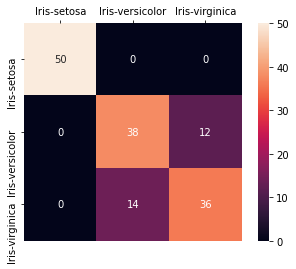

Accuracy: 0.83


In [20]:
kmeans = KMeans(n_clusters=3, random_state=0)

cv_matrix = cross_val_clusters(kmeans, 10, X, y)
plot_confusion(cv_matrix)

acc = np.trace(cv_matrix)/len(X)
print("Accuracy: " + str(round(acc,2)))

### 2.3 Gaussian Mixture

A Gaussian Mixture model is a probabilistic model for representing the presence of subpopulations within an overall population, where each sub-population is modelled according to a different Gaussian distribution. Being an unsupervised algorithm, it does not required that an observed dataset should identify the sub-population to which an individual observation belongs. 

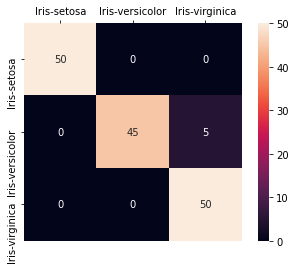

Accuracy: 0.97


In [19]:
gaussian = GaussianMixture(n_components=3, random_state=0)

cv_matrix = cross_val_clusters(gaussian, 10, X, y)
plot_confusion(cv_matrix)

acc = np.trace(cv_matrix)/len(X)
print("Accuracy: " + str(round(acc,2)))

### 2.4 SOM

A self-organizing map (SOM) is a type of artificial neural network that is trained using unsupervised learning to produce a low-dimensional (typically two-dimensional), discretized representation of the input space of the training samples, called a map, and is therefore a method to do dimensionality reduction. They apply competitive learning as opposed to error-correction learning (such as backpropagation with gradient descent), and in the sense that they use a neighborhood function to preserve the topological properties of the input space.

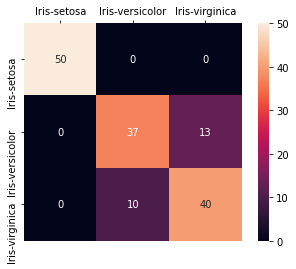

Accuracy: 0.85


In [17]:
mapsize = [20,20]
som = sompy.SOMFactory

cv_matrix = cross_val_clusters(som, 10, X, y)
plot_confusion(cv_matrix)

acc = np.trace(cv_matrix)/len(X)
print("Accuracy: " + str(round(acc,2)))

### 2.5 Exercise 2 conclusions

Kmeans and SOM models predicted the labels of new data with approximately the same accuracy (~0.83). In both these models, *Iris setosa* predictions were highly accurate (very close to 1), while *Iris virginica* and *Iris versicolor* had more misclassifications. This is indicative of partial cluster overlap. Furthermore, the similar results between these two models was expected, since SOMPY uses KMeans to group the trained neurons into clusters (see "def cluster" in the [SOMPY code](https://github.com/sevamoo/SOMPY/blob/master/sompy/sompy.py)). Due to their similar accuracy, we would preferr using KMeans rather that SOMPY for the current problem, since the latter is computationally more expensive. However, other datasets may benefit from using SOMPY, allying both the dimensionality reduction properties of SOM and neuron clustering capabilities of Kmeans.

The Gaussian mixture model had an accuracy of 0.97, only misclassifiying 5 *Iris versicolor*, implying the algorithm achieved minimal overlap between the clusters. Overall we can conclude that the Gaussian Mixture is the best cluster model for this dataset.